In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

### Получим данные:

In [2]:
# будем решать задачу регрессии Housing Prices

from sklearn.datasets import load_boston
import pandas as pd
from keras.datasets import boston_housing
%matplotlib inline

Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()
boston = load_boston()
lables = boston.feature_names
data_train = pd.DataFrame(data = X_train, index = range(1, len(X_train)+1), columns = lables)
data_test = pd.DataFrame(data = X_test, index = range(1, len(X_test)+1), columns = lables)
data_train.insert(value = y_train, column = 'PRICE', loc = 13)
data_test.insert(value = y_test, column = 'PRICE', loc = 13)

In [4]:
data_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
1,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
2,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
3,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
4,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
5,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [5]:
data_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
1,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05,7.2
2,0.12329,0.0,10.01,0.0,0.547,5.913,92.9,2.3534,6.0,432.0,17.8,394.95,16.21,18.8
3,0.05497,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74,19.0
4,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50,27.0
5,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2


Text(0.5,0,'Price')

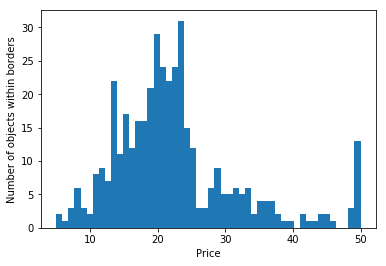

In [6]:
plt.hist(y_train, bins=50)
plt.ylabel('Number of objects within borders')
plt.xlabel('Price')

### Строим нейронную сеть с помощью PyTorch:

In [7]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F

In [8]:
torch.manual_seed(1)    # random_state для воспроизводимости результатов

In [9]:
# преобразуем данные для PyTorch

X_train = Variable(torch.FloatTensor(X_train))
y_train = torch.unsqueeze(torch.FloatTensor(y_train), dim=1)

In [10]:
# нейронная сеть

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   
        self.predict = torch.nn.Linear(n_hidden, n_output)  

    def forward(self, X):
        X = F.relu(self.hidden(X))      
        X = self.predict(X)             
        return X

In [11]:
net = Net(n_feature=len(lables), n_hidden=10, n_output=1)     

In [12]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss() 

In [13]:
# сюда пишем ошибки и дисперсию

errors = {'train': [], 'test_mean': [], 'test_var' : []}

In [14]:
# для оценки дисперсии

from random import choice

In [15]:
def learning_curve(estimator):
    for t in range(43):  # итерации обучения
        prediction = estimator(X_train)     
        loss_train = loss_func(prediction, y_train)     
        
        optimizer.zero_grad()   
        loss_train.backward()       
        optimizer.step()       
        
        inter_test_errors = []
        for i in range(20):  # оценка результата обучения на случайных выборках
            X_test_iter = []
            y_test_iter = []
            for i in range(300):  #  генерируем выборку размера 300
                to_add = choice(range(len(X_test[0])))
                X_test_iter.append(X_test[to_add])
                y_test_iter.append(y_test[to_add])
            X_test_iter = Variable(torch.FloatTensor(X_test_iter))
            y_test_iter = torch.unsqueeze(torch.FloatTensor(y_test_iter), dim=1)
            prediction = estimator(X_test_iter)
            loss_test = loss_func(prediction, y_test_iter)
            inter_test_errors.append(loss_test.item())
        errors['train'].append(loss_train.item())
        errors['test_mean'].append(np.mean(inter_test_errors))
        errors['test_var'].append(np.std(inter_test_errors))
    return errors

In [16]:
# функция вернет построенную кривую обучения для нашей сети

def plot_learning_curve(estimator, title, X, y):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training iteration")
    plt.ylabel("Score")
    scores = learning_curve(estimator)

    plt.grid()

    plt.fill_between(np.array(range(30, len(scores['test_mean']))), 
                     np.array(scores['test_mean'][30:]) - np.array(scores['test_var'][30:]), 
                     np.array(scores['test_mean'][30:]) + np.array(scores['test_var'][30:]),
                     alpha=0.1,
                     color="g")

    plt.plot(range(30, len(scores['test_mean'])), scores['test_mean'][30:], 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    return plt

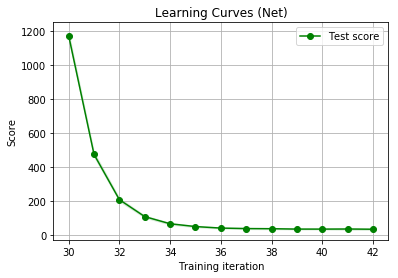

In [17]:
# строим кривую обучения

title = "Learning Curves (Net)"

plot_learning_curve(net, title, X_train, y_train)

plt.show()

In [18]:
# посмотрим на дисперсию, чтобы убедиться, что она есть, но маленькая

print([error for error in errors['test_var']][30:])

[20.167507317649864, 14.462499811863823, 10.33335990885519, 6.9418609120023307, 5.8834015273126763, 4.6977557752890036, 3.1366536301478725, 3.4093890153197464, 3.8649623244369375, 3.140626189214669, 3.0029915097755682, 4.6840187469589711, 4.0292261283427298]


#### Выводы:
Ошибка уменьшается на каждом шаге обучения сетки. Дисперсия небольшая (как видно на output'e на клетку выше) и не видна на графике. Результат рассматриваем, начиная с 30-го шага, так как ошибка до этого момента слишком большая, что не позволяет увидеть асимптотику.